In [ ]:
!pip3 install 'faiss_cpu>=1.7.1'

In [ ]:
from PIL import Image
from skimage import data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import numpy as np
import logging
import torchvision
from torch import nn
from scipy import spatial
from skimage import feature
from skimage import measure
import torchvision.transforms as T

import faiss
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

import logging
from tqdm import tqdm
from typing import Tuple
from argparse import Namespace
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader, Dataset
import os, sys
import warnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --upgrade --no-cache-dir gdown

if not os.path.isfile('sf_xs.zip'):
  !gdown 1Q_JGBHk5iN_lqA6OR5tBEZc_Lb-0wQ5b
  !jar xvf  "/content/sf_xs.zip"

if not os.path.isdir('sf_xs.zip'):
  print("Dataset doesn't exist")

if not os.path.isfile('/content/tokyo_xs.zip'):
  !gdown 1Zya9NnGOZqAXo0b9Z4YfD5qPXpVq8p14
  !jar xvf  "/content/tokyo_xs.zip"

if not os.path.isdir('tokyo_xs'):
  print("Dataset doesn't exist")

if not os.path.isfile('/content/tokyo_night.zip'):
  !gdown 1idC1UBdwSap_Nx1SZVDhRDHJI3LQn5E3
  !jar xvf  "/content/tokyo_night.zip"

if not os.path.isdir('tokyo_night'):
  print("Dataset doesn't exist")

## Test Dataset

In [ ]:
import os
import numpy as np
from glob import glob
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.neighbors import NearestNeighbors


def open_image(path):
    return Image.open(path).convert("RGB")


class TestDataset(data.Dataset):
    def __init__(self, dataset_folder, database_folder="database",
                 queries_folder="queries", positive_dist_threshold=25):        
        """Dataset with images from database and queries, used for validation and test.
        Parameters
        ----------
        dataset_folder : str, should contain the path to the val or test set,
            which contains the folders {database_folder} and {queries_folder}.
        database_folder : str, name of folder with the database.
        queries_folder : str, name of folder with the queries.
        positive_dist_threshold : int, distance in meters for a prediction to
            be considered a positive.
        """
        super().__init__()
        self.dataset_folder = dataset_folder
        self.database_folder = os.path.join(dataset_folder, database_folder)    
        self.queries_folder = os.path.join(dataset_folder, queries_folder)
        self.dataset_name = os.path.basename(dataset_folder)               

        if not os.path.exists(self.dataset_folder):
            raise FileNotFoundError(f"Folder {self.dataset_folder} does not exist")
        if not os.path.exists(self.database_folder):
            raise FileNotFoundError(f"Folder {self.database_folder} does not exist")
        if not os.path.exists(self.queries_folder):
            raise FileNotFoundError(f"Folder {self.queries_folder} does not exist")    

        self.base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    
        ])

        #### Read paths and UTM coordinates for all images.
        self.database_paths = sorted(glob(os.path.join(self.database_folder, "**", "*.jpg"), recursive=True)) 
        self.queries_paths = sorted(glob(os.path.join(self.queries_folder, "**", "*.jpg"),  recursive=True))

        # The format must be path/to/file/@utm_easting@utm_northing@...@.jpg
        self.database_utms = np.array([(path.split("@")[1], path.split("@")[2]) for path in self.database_paths]).astype(float) 
        self.queries_utms = np.array([(path.split("@")[1], path.split("@")[2]) for path in self.queries_paths]).astype(float)

        # Find positives_per_query, which are within positive_dist_threshold (default 25 meters)
        knn = NearestNeighbors(n_jobs=-1)          
                                            
        knn.fit(self.database_utms)              
        self.positives_per_query = knn.radius_neighbors(self.queries_utms,                 
                                                        radius=positive_dist_threshold,  
                                                        return_distance=False)


        self.images_paths = [p for p in self.database_paths]       
        self.images_paths += [p for p in self.queries_paths]        

        self.database_num = len(self.database_paths)               
        self.queries_num = len(self.queries_paths)

    def __getitem__(self, index):
        image_path = self.images_paths[index]                       
        pil_img = open_image(image_path)                     
        normalized_img = self.base_transform(pil_img)             
        return normalized_img, index, image_path

    def __len__(self):
        return len(self.images_paths)

    def __repr__(self):
        return f"< {self.dataset_name} - #q: {self.queries_num}; #db: {self.database_num} >"       

    def get_positives(self):
        return self.positives_per_query                        


## Model

#### Layers

In [ ]:
def gem(x, p=torch.ones(1)*3, eps: float = 1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})"

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        assert x.shape[2] == x.shape[3] == 1, f"{x.shape[2]} != {x.shape[3]} != 1"
        return x[:, :, 0, 0]

class L2Norm(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return F.normalize(x, p=2.0, dim=self.dim)


class Attention(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.conv1 = nn.Conv2d(input_features, 512, 1, 1, padding='same')


        self.bn = nn.BatchNorm2d(512)


        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(512, 1, 1, 1, padding='same')
        self.softplus = nn.Softplus()



    def forward(self, x, rec_feature_map=None):
        input = x
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)

        score = self.conv2(x)
        prob = self.softplus(score)


        if rec_feature_map is None:
            rec_feature_map = input

        rec_feature_map_norm = F.normalize(rec_feature_map, p=2, dim=1)
        att = torch.mul(rec_feature_map_norm, prob)
        feat = torch.mean(att, [2, 3])
        return feat, prob, att

class Autoencoder(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        self.conv1 = nn.Conv2d(input_features, output_features, 1, 1, padding='same')
        self.conv2 = nn.Conv2d(output_features, input_features, 1, 1, padding='same')
        self.relu = nn.ReLU()

    def forward(self, x):
        reduced_dim = self.conv1(x)
        x = self.conv2(reduced_dim)
        expanded_dim = self.relu(x)
        return reduced_dim, expanded_dim

#### Network (after)

In [ ]:
CHANNELS_NUM_IN_LAST_CONV = {
        "resnet18": 512,
        "resnet50": 2048,
        "resnet101": 2048,
        "resnet152": 2048,
        "vgg16": 512,
    }

CHANNELS_NUM_AFTER_LAYER_3 = {
        "resnet18": 256,
        "resnet50": 1024
    }

class GeoLocalizationNet(nn.Module):
    def __init__(self, backbone, fc_output_dim, fm_reduction_dim, reduction, num_classes=5965):
        super().__init__()
        backbone_after_3, layers_4, features_dim, features_map_dim = get_backbone(backbone)
        self.backbone_after_3 = backbone_after_3
        self.layers_4 = layers_4
        self.aggregation = nn.Sequential(
                L2Norm(),
                GeM(),
                Flatten(),
                nn.Linear(features_dim, fc_output_dim),
                L2Norm()
            )
        self.attention = Attention(features_map_dim)
        self.dim_reduction = reduction
        if self.dim_reduction:
            self.autoencoder = Autoencoder(features_map_dim, fm_reduction_dim)

        self.attn_classifier = nn.Linear(features_map_dim, num_classes)

    def forward(self, x):
        feature_map = self.backbone_after_3(x)

        x = self.layers_4(feature_map)

        global_features = self.aggregation(x)

        feature_map = feature_map.detach()


        if self.dim_reduction:
            red_feature_map, rec_feature_map = self.autoencoder(feature_map)
        else:
            rec_feature_map = feature_map
            red_feature_map = feature_map
        attn_prelogits, attn_scores, _ = self.attention(feature_map, rec_feature_map)

        attn_logits = self.attn_classifier(attn_prelogits)
        return global_features, attn_logits, feature_map, rec_feature_map, red_feature_map, attn_scores


def get_backbone(backbone_name):
    if backbone_name.startswith("resnet"):
        if backbone_name == "resnet18":
            backbone = torchvision.models.resnet18(pretrained=True)
        elif backbone_name == "resnet50":
            backbone = torchvision.models.resnet50(pretrained=True)
        elif backbone_name == "resnet101":
            backbone = torchvision.models.resnet101(pretrained=True)
        elif backbone_name == "resnet152":
            backbone = torchvision.models.resnet152(pretrained=True)

        for name, child in backbone.named_children():

            if name == "layer3":
                break
            for params in child.parameters():
                params.requires_grad = False
        logging.debug(f"Train only layer3 and layer4 of the {backbone_name}, freeze the previous ones")
        backbone_after_3 = list(backbone.children())[:-3]
        layers_4 = list(backbone.children())[-3]


    elif backbone_name == "vgg16":
        backbone = torchvision.models.vgg16(pretrained=True)
        layers = list(backbone.features.children())[:-2]
        for layer in layers[:-5]:
            for p in layer.parameters():
                p.requires_grad = False
        logging.debug("Train last layers of the VGG-16, freeze the previous ones")

    backbone_after_3 = torch.nn.Sequential(*backbone_after_3)

    features_dim = CHANNELS_NUM_IN_LAST_CONV[backbone_name]

    features_map_dim = CHANNELS_NUM_AFTER_LAYER_3[backbone_name]
    return backbone_after_3, layers_4, features_dim, features_map_dim

#### Loading model

In [ ]:
reduced_dim = 128
model_name = "res50_red128_3+9"
model = GeoLocalizationNet('resnet50', 512, reduced_dim, True)
model_path = "drive/MyDrive/best_model_res50_bs32_red128_3+9.pth"

best_model_state_dict = torch.load(model_path)
model.load_state_dict(best_model_state_dict)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 74.7MB/s]


<All keys matched successfully>

# Eval

In [ ]:
RECALL_VALUES = [1, 5, 10, 20]

eval_ds = TestDataset("tokyo_night/test", queries_folder="queries",
                      positive_dist_threshold=25)


model = model.to("cuda")
model = model.eval()
with torch.no_grad():
    logging.debug("Extracting database descriptors for evaluation/testing")
    database_subset_ds = Subset(eval_ds, list(range(eval_ds.database_num)))
    database_dataloader = DataLoader(dataset=database_subset_ds, num_workers=8,
                                      batch_size=16, pin_memory=("cuda" == "cuda"))
    all_descriptors = np.empty((len(eval_ds), 512), dtype="float32")
    all_local_descriptors = np.empty((len(eval_ds), reduced_dim, 14, 14), dtype="float32")
    all_att_prob = np.empty((len(eval_ds), 1, 14, 14), dtype="float32")


    for images, indices, _ in tqdm(database_dataloader, ncols=100):
        global_descriptors, _, _, _, local_descriptors, attn_scores = model(images.to("cuda"))
        global_descriptors = global_descriptors.cpu().numpy()
        local_descriptors = local_descriptors.cpu().numpy()
        attn_scores = attn_scores.cpu().numpy()
        all_descriptors[indices.numpy(), :] = global_descriptors
        all_local_descriptors[indices.numpy(), :] = local_descriptors
        all_att_prob[indices.numpy(), :] = attn_scores


    logging.debug("Extracting queries descriptors for evaluation/testing using batch size 1")
    queries_infer_batch_size = 1
    queries_subset_ds = Subset(eval_ds, list(range(eval_ds.database_num, eval_ds.database_num+eval_ds.queries_num)))
    queries_dataloader = DataLoader(dataset=queries_subset_ds, num_workers=8,
                                    batch_size=queries_infer_batch_size, pin_memory=("cuda" == "cuda"))
    for images, indices, _ in tqdm(queries_dataloader, ncols=100):
        global_descriptors, _, _, _, local_descriptors, attn_scores = model(images.to("cuda"))
        global_descriptors = global_descriptors.cpu().numpy()
        local_descriptors = local_descriptors.cpu().numpy()
        attn_scores = attn_scores.cpu().numpy()
        all_descriptors[indices.numpy(), :] = global_descriptors
        all_local_descriptors[indices.numpy(), :] = local_descriptors
        all_att_prob[indices.numpy(), :] = attn_scores

queries_global_descriptors = all_descriptors[eval_ds.database_num:]
queries_local_descriptors = all_local_descriptors[eval_ds.database_num:]
queries_att_prob = all_att_prob[eval_ds.database_num:]

database_global_descriptors = all_descriptors[:eval_ds.database_num]
database_local_descriptors = all_local_descriptors[:eval_ds.database_num]
database_att_prob = all_att_prob[:eval_ds.database_num]


In [ ]:
print(eval_ds.database_num)
print(eval_ds.queries_num)

print(database_local_descriptors.shape)
print(database_att_prob.shape)

print(queries_local_descriptors.shape)
print(queries_att_prob.shape)

In [ ]:
faiss_index = faiss.IndexFlatL2(512)
faiss_index.add(database_global_descriptors)

In [ ]:
distances, predictions = faiss_index.search(queries_global_descriptors, max(RECALL_VALUES))
positives_per_query = eval_ds.get_positives()

In [ ]:
print(distances.shape)
print(predictions.shape)

(105, 20)
(105, 20)


In [ ]:
query_index = 46
print(predictions[query_index])
print(positives_per_query[query_index])

[ 5617  5702  2050  6939  5701  8247  8298  5996 10337  2655 12757  1848
  9799  9471  4891  4567  8255  9291  8258 12586]
[5855 5555 5554 5552 5553 5819 5618 5856 5617 5616 5703 5822 5820 5821
 5700 5701 5702 5753 5752 5751 5750 5749 5748 5747 5746 5745 5704 5705
 5713 5760 5712 5711 5758 5757 5813 5754 5816 5815 5755 5756 5814 5759
 5715 5714 5716 5668 5667 5666 5665 5670 5669]


# Test

## Local features utils

#### utils

In [ ]:
def retrive_locations_and_descriptors(attn_scores, red_feature_map, original_image_size=224, k=85):
  attn_scores = np.transpose(attn_scores, (1, 2, 0))
  red_feature_map = np.transpose(red_feature_map, (1, 2, 0))
  flat_indices = np.argpartition(attn_scores.flatten(), -k)[-k:]
  sorted_indices = flat_indices[np.argsort(attn_scores.flatten()[flat_indices])][::-1]
  k_coords = np.unravel_index(sorted_indices, attn_scores.shape)
  x_coords, y_coords = k_coords[:-1]

  local_descriptors_ij = list(zip(x_coords, y_coords))

  region_size = original_image_size//attn_scores.shape[1]
  x_loc = x_coords*region_size+region_size//2
  y_loc = y_coords*region_size+region_size//2

  local_descriptors_locations = np.array(list(zip(x_loc, y_loc)))

  filtered_local_descriptors = []
  for i, j in local_descriptors_ij:
    filtered_local_descriptors.append(red_feature_map[i, j, :])
  local_descriptors = np.array(filtered_local_descriptors)

  local_descriptors = torch.from_numpy(local_descriptors)
  local_descriptors = F.normalize(local_descriptors, p=2, dim=1).numpy()
  return local_descriptors_locations, local_descriptors

#### Match features

In [ ]:
from skimage import transform
from skimage.measure import ransac
import time

def match_features(query_locations,
                  query_descriptors,
                  image_locations,
                  image_descriptors,
                  descriptor_matching_threshold=0.65,
                  ransac_residual_threshold=15.0,
                  query_im_array=None,
                  index_im_array=None,
                  ransac_seed=4,
                  use_ratio_test=False,
                  RANSAC=False):


    num_features_query = query_locations.shape[0]
    num_features_image = image_locations.shape[0]
    if not num_features_query or not num_features_image:
        print(f"database images or query image don't have consistent dimension")

    local_feature_dim = query_descriptors.shape[1]
    if image_descriptors.shape[1] != local_feature_dim:
        print(f"Local feature dimensionality is not consistent for query and database images.")


    index_image_tree = spatial.cKDTree(image_descriptors)
    if use_ratio_test:
        distances, indices = index_image_tree.query(query_descriptors, k=2, workers=-1)

        query_locations_to_use = np.array([
            query_locations[i,]
            for i in range(num_features_query)
            if distances[i][0] < descriptor_matching_threshold * distances[i][1]
        ])
        image_locations_to_use = np.array([
            image_locations[indices[i][0],]
            for i in range(num_features_query)
            if distances[i][0] < descriptor_matching_threshold * distances[i][1]
        ])
    else:
      _, indices = index_image_tree.query(query_descriptors, distance_upper_bound=descriptor_matching_threshold, workers=-1)
      query_locations_to_use = np.array([query_locations[i,] for i in range(num_features_query) if indices[i] != num_features_image])

      image_locations_to_use = np.array([image_locations[indices[i],] for i in range(num_features_query)
                                  if indices[i] != num_features_image])


    if RANSAC:
      _NUM_RANSAC_TRIALS = 100
      _MIN_RANSAC_SAMPLES = 3

      if query_locations_to_use.shape[0] <= _MIN_RANSAC_SAMPLES:
          return 0

      with warnings.catch_warnings():
          warnings.filterwarnings('ignore', 'No inliers found. Model not fitted', UserWarning)
          _, inliers = ransac(
              (image_locations_to_use, query_locations_to_use),
              transform.AffineTransform,
              min_samples=_MIN_RANSAC_SAMPLES,
              residual_threshold=ransac_residual_threshold,
              max_trials=_NUM_RANSAC_TRIALS,
              random_state=ransac_seed)

      if inliers is None:
          inliers = []
      elif query_im_array is not None and index_im_array is not None:
        plot_inlier_lines(query_im_array, index_im_array, query_locations_to_use, image_locations_to_use, inliers)
      return sum(inliers)
    else:
      return image_locations_to_use.shape[0]


def plot_inlier_lines(query_im_array, index_im_array, query_locations, index_locations, inliers):
    inlier_idxs = np.nonzero(inliers)[0]

    fig, ax = plt.subplots()
    ax.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)

    feature.plot_matches(ax,
                         index_im_array,
                          query_im_array,
                         index_locations,
                         query_locations,
                         np.column_stack((inlier_idxs, inlier_idxs)),
                         only_matches=True,)

    plt.show()



# Test (singola)

#### Loading e model

In [ ]:
def pil_loader(path):

    with open(path, 'rb') as f:
        img = Image.open(f)                
        return img.convert('RGB')

In [ ]:
image_id = 5702
img1 = eval_ds[image_id][0].numpy()
path1 = eval_ds[image_id][2]
print(path1)

img2 = eval_ds[eval_ds.database_num + query_index][0].numpy()
path2 = eval_ds[eval_ds.database_num + query_index][2]
print(path2)

img1 = pil_loader(path1)
img2 = pil_loader(path2)

tokyo_night/test/database/@0382149.73@3946453.01@54@S@035.65489@0139.69809@tBZC0swtq0Te1g6uMGR89w@02@@@@@@@.jpg
tokyo_night/test/queries/@0382147.66@3946452.27@54@S@035.65488@0139.69806@00429.jpg@@@@@@@@.jpg


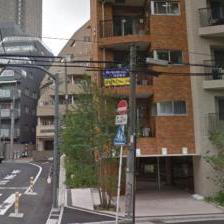

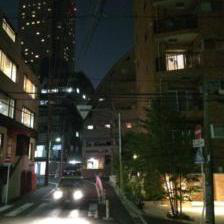

In [ ]:
train_transform = T.Compose([
                              T.ToTensor(),
                              T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

image1 = img1
image2 = img2


display(image1)
display(image2)


image1 = train_transform(image1).unsqueeze(0)
image1 = image1.to("cuda")

image2 = train_transform(image2).unsqueeze(0)
image2 = image2.to("cuda")

model = model.to("cuda").eval()

database_descriptors = np.empty((3, 512), dtype="float32")
queries_descriptors = np.empty((2, 512), dtype="float32")

global_features1, attn_logits, feature_map, rec_feature_map, red_feature_map_query, attn_scores_query = model(image1)
global_features2, attn_logits, feature_map, rec_feature_map, red_feature_map_image, attn_scores_image = model(image2)

red_feature_map_query = red_feature_map_query.squeeze(0).detach().cpu().numpy()
attn_scores_query = attn_scores_query.squeeze(0).detach().cpu().numpy()

red_feature_map_image = red_feature_map_image.squeeze(0).detach().cpu().numpy()
attn_scores_image = attn_scores_image.detach().squeeze(0).cpu().numpy()

# Visualization

In [ ]:
import cv2

def show_attention_map(img):
    image = train_transform(img).unsqueeze(0).to("cuda")
    global_features, _, feature_map, _, red_feature_map, attn_scores = model(image)

    attn_scores = attn_scores.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
    red_feature_map = red_feature_map.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()

    print(red_feature_map.shape)

    fig = plt.figure(figsize=(3, 3), frameon=False)
    extent = 0, 224, 0, 224

    img = np.array(img)
    # img = cv2.resize(img, (224, 224))
    im1 = plt.imshow(img, extent=extent)

    heatmap = cv2.resize(attn_scores, (224, 224), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)
    im2 = plt.imshow(heatmap, cmap=plt.cm.viridis, alpha=.4, interpolation='bilinear', extent=extent)
    plt.axis('off')
    # k = 0
    # flat_indices = np.argpartition(attn_scores.flatten(), -k)[-k:]  # ottieni gli indici dei k valori massimi
    # sorted_indices = flat_indices[np.argsort(attn_scores.flatten()[flat_indices])][::-1]  # ordina gli indici in base ai valori
    # k_coords = np.unravel_index(sorted_indices, attn_scores.shape)  # converte gli indici in coordinate (x, y)
    # x_coords, y_coords = k_coords[:-1]

    # local_descriptors_ij = list(zip(x_coords, y_coords))  # crea una lista di coppie di coordinate

    # x_loc = k_coords[1]*16+8
    # y_loc = 216-k_coords[0]*16
    # local_descriptors_locations = list(zip(x_loc, y_loc))
    # print(local_descriptors_locations)


    # for loc in local_descriptors_locations:
    #   plt.scatter(loc[0], loc[1], color='red', s=20)
    # plt.colorbar()

    plt.show()




(14, 14, 128)


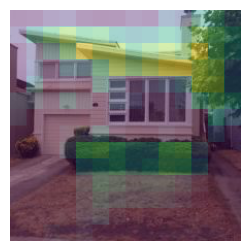

In [ ]:
show_attention_map(img2)

# other

#### test local

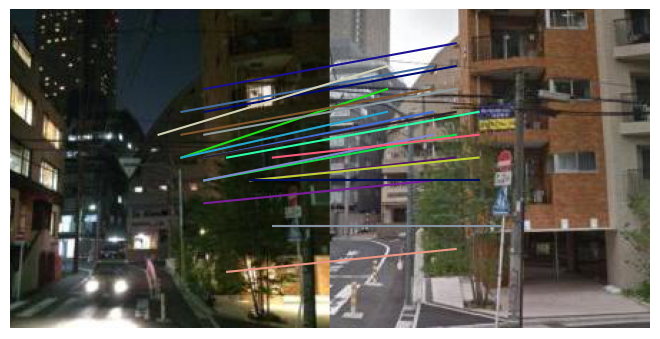

 21


In [ ]:
query_locations, selected_features_query = retrive_locations_and_descriptors(attn_scores_query, red_feature_map_query)
image_locations, selected_features_image = retrive_locations_and_descriptors(attn_scores_image, red_feature_map_image)

image1 = img1
image2 = img2

query = np.array(image1)
image = np.array(image2)

inliers = match_features(
          query_locations,
          selected_features_query,
          image_locations,
          selected_features_image,
          descriptor_matching_threshold=0.65,
          ransac_residual_threshold=15,
          query_im_array=query,
          index_im_array=image,
          use_ratio_test=False,
          RANSAC=True)


print(f"{inliers: }")

# Reranked

## functions

In [ ]:
def RerankByGeometricVerification(query_predictions, distances, query_descriptors, query_attention_prob,
                    images_local_descriptors, images_attention_prob, k, descriptor_matching_threshold, ransac_residual_threshold):

    query_locations, query_descriptors = retrive_locations_and_descriptors(query_attention_prob, query_descriptors, k=k)

    inliers_and_initial_scores = []
    for i, preds in enumerate(query_predictions):

        image_locations, image_descriptors = retrive_locations_and_descriptors(images_attention_prob[i], images_local_descriptors[i], k=k)

        inliers = match_features(
            query_locations,
            query_descriptors,
            image_locations,
            image_descriptors,
            descriptor_matching_threshold,
            ransac_residual_threshold,
            use_ratio_test=False,
            RANSAC=True)

        inliers_and_initial_scores.append([preds, inliers, distances[i]])


    inliers_and_initial_scores = sorted(inliers_and_initial_scores, key=lambda x : (x[1], -x[2]), reverse=True)

    new_rank = [x[0] for x in inliers_and_initial_scores]

    return new_rank

In [ ]:
def track_position_changes(predictions, positives_per_query, reranked_preds):
  pos_before_after_rerank = []
  for val in positives_per_query:
      if val in predictions and val in reranked_preds:
          pos_before = predictions.tolist().index(val)
          pos_after = reranked_preds.index(val)
          pos_before_after_rerank.append([val, f"{pos_before} -> {pos_after}"])

  print(pos_before_after_rerank)

## main

In [ ]:
RECALL_VALUES = [1, 5, 10, 20]
recalls = np.zeros(len(RECALL_VALUES))
reranked_recalls = np.zeros(len(RECALL_VALUES))

reranked_preds = RerankByGeometricVerification(predictions[query_index], distances[query_index], queries_local_descriptors[query_index],
                            queries_att_prob[query_index], database_local_descriptors[predictions[query_index]], database_att_prob[predictions[query_index]],
                            k=85, descriptor_matching_threshold=0.65, ransac_residual_threshold=15.0)


track_position_changes(predictions[query_index], positives_per_query[query_index], reranked_preds)
for i, n in enumerate(RECALL_VALUES):
    reranked_recalls[i:] += np.sum(np.in1d(reranked_preds[:n], positives_per_query[query_index]))

for i, n in enumerate(RECALL_VALUES):
    recalls[i:] += np.sum(np.in1d(predictions[query_index][:n], positives_per_query[query_index]))

recalls_str = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(RECALL_VALUES, recalls)])
reranked_recalls_str = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(RECALL_VALUES, reranked_recalls)])

print('Recalls \t', recalls_str)
print('Reranked Recalls', reranked_recalls_str)

[[5617, '0 -> 8'], [5701, '4 -> 1'], [5702, '1 -> 0']]
Recalls 	 R@1: 1.0, R@5: 4.0, R@10: 7.0, R@20: 10.0
Reranked Recalls R@1: 1.0, R@5: 3.0, R@10: 6.0, R@20: 9.0


# Parameter tuning

## Test local features

### Load dataset

In [ ]:
RECALL_VALUES = [1, 5, 10, 20]


eval_ds = TestDataset("sf_xs/val", queries_folder="queries",
                      positive_dist_threshold=25)

model = model.to("cuda")
model = model.eval()
with torch.no_grad():
    logging.debug("Extracting database descriptors for evaluation/testing")
    database_subset_ds = Subset(eval_ds, list(range(eval_ds.database_num)))
    database_dataloader = DataLoader(dataset=database_subset_ds, num_workers=8,
                                      batch_size=16, pin_memory=("cuda" == "cuda"))
    all_descriptors = np.empty((len(eval_ds), 512), dtype="float32")
    all_local_descriptors = np.empty((len(eval_ds), reduced_dim, 14, 14), dtype="float32")
    all_att_prob = np.empty((len(eval_ds), 1, 14, 14), dtype="float32")


    for images, indices, _ in tqdm(database_dataloader, ncols=100):
        global_descriptors, _, _, _, local_descriptors, attn_scores = model(images.to("cuda"))
        global_descriptors = global_descriptors.cpu().numpy()
        local_descriptors = local_descriptors.cpu().numpy()
        attn_scores = attn_scores.cpu().numpy()
        all_descriptors[indices.numpy(), :] = global_descriptors
        all_local_descriptors[indices.numpy(), :] = local_descriptors
        all_att_prob[indices.numpy(), :] = attn_scores


    logging.debug("Extracting queries descriptors for evaluation/testing using batch size 1")
    queries_infer_batch_size = 1
    queries_subset_ds = Subset(eval_ds, list(range(eval_ds.database_num, eval_ds.database_num+eval_ds.queries_num)))
    queries_dataloader = DataLoader(dataset=queries_subset_ds, num_workers=8,
                                    batch_size=queries_infer_batch_size, pin_memory=("cuda" == "cuda"))
    for images, indices, _ in tqdm(queries_dataloader, ncols=100):
        global_descriptors, _, _, _, local_descriptors, attn_scores = model(images.to("cuda"))
        global_descriptors = global_descriptors.cpu().numpy()
        local_descriptors = local_descriptors.cpu().numpy()
        attn_scores = attn_scores.cpu().numpy()
        all_descriptors[indices.numpy(), :] = global_descriptors
        all_local_descriptors[indices.numpy(), :] = local_descriptors
        all_att_prob[indices.numpy(), :] = attn_scores

queries_global_descriptors = all_descriptors[eval_ds.database_num:]
queries_local_descriptors = all_local_descriptors[eval_ds.database_num:]
queries_att_prob = all_att_prob[eval_ds.database_num:]

database_global_descriptors = all_descriptors[:eval_ds.database_num]
database_local_descriptors = all_local_descriptors[:eval_ds.database_num]
database_att_prob = all_att_prob[:eval_ds.database_num]

faiss_index = faiss.IndexFlatL2(512)
faiss_index.add(database_global_descriptors)
del all_local_descriptors, all_descriptors, all_att_prob

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|███████████████████████████████████████████████████████████| 7993/7993 [01:38<00:00, 81.16it/s]


### downloading descriptors

In [ ]:
from google.colab import files
import pickle
import math

# nome_file = "queries_global_descriptors.pkl"
# file = open(nome_file, 'wb')
# pickle.dump(queries_global_descriptors, file)
# file.close()
# files.download(nome_file)

# nome_file = "queries_local_descriptors.pkl"
# file = open(nome_file, 'wb')
# pickle.dump(queries_local_descriptors, file)
# file.close()
# files.download(nome_file)

# nome_file = "queries_att_prob.pkl"
# file = open(nome_file, 'wb')
# pickle.dump(queries_att_prob, file)
# file.close()
# files.download(nome_file)

# nome_file = "database_global_descriptors.pkl"
# file = open(nome_file, 'wb')
# pickle.dump(database_global_descriptors, file)
# file.close()
# files.download(nome_file)

# nome_file = "database_local_descriptors.pkl"
# file = open(nome_file, 'wb')
# pickle.dump(database_local_descriptors, file)
# file.close()
# files.download(nome_file)

# nome_file = "database_att_prob.pkl"
# file = open(nome_file, 'wb')
# pickle.dump(database_att_prob, file)
# file.close()
# files.download(nome_file)

# positives_per_query = eval_ds.get_positives()
# nome_file = "positives_per_query.pkl"
# file = open(nome_file, 'wb')
# pickle.dump(positives_per_query, file)
# file.close()
# files.download(nome_file)

# chunk_size = 500
# total_elements = database_local_descriptors.shape[0]
# print(total_elements)

# for i in range(math.ceil(total_elements / chunk_size)):
#     start_index = i * chunk_size
#     end_index = min((i + 1) * chunk_size, total_elements)

#     nome_file = f"database_local_descriptors{i+1}.pkl"
#     file = open(nome_file, 'wb')
#     pickle.dump(database_local_descriptors[start_index:end_index], file)
#     file.close()
#     if i == 15:
#       files.download(nome_file)

# if total_elements % chunk_size != 0:
#     remaining_elements = database_local_descriptors[end_index:]
#     nome_file = f"database_local_descriptors_final.pkl"
#     file = open(nome_file, 'wb')
#     pickle.dump(remaining_elements, file)
#     file.close()
    # files.download(nome_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Computing recalls

In [ ]:
print(model_name)
RANSAC = False
logging.debug("Calculating recalls")
distances, predictions = faiss_index.search(queries_global_descriptors, max(RECALL_VALUES))
positives_per_query = eval_ds.get_positives()
for k in [80, 85]:
  for th in [0.8, 0.85, 0.9]:
    for ransac_th in [5.0]:
      recalls = np.zeros(len(RECALL_VALUES))
      reranked_recalls = np.zeros(len(RECALL_VALUES))
      for query_index, preds in enumerate(tqdm(predictions, ncols=100)):
          reranked_preds = RerankByGeometricVerification(preds, distances[query_index], queries_local_descriptors[query_index],
                                      queries_att_prob[query_index], database_local_descriptors[preds], database_att_prob[preds],
                                      k=k, descriptor_matching_threshold=th, ransac_residual_threshold=ransac_th)
          for i, n in enumerate(RECALL_VALUES):
            if np.any(np.in1d(reranked_preds[:n], positives_per_query[query_index])):
                reranked_recalls[i:] += 1
                break
          for i, n in enumerate(RECALL_VALUES):
            if np.any(np.in1d(preds[:n], positives_per_query[query_index])):
                recalls[i:] += 1
                break

      recalls = recalls / eval_ds.queries_num * 100
      reranked_recalls = reranked_recalls / eval_ds.queries_num * 100

      recalls_str = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(RECALL_VALUES, recalls)])
      reranked_recalls_str = ", ".join([f"R@{val}: {rec:.1f}" for val, rec in zip(RECALL_VALUES, reranked_recalls)])

      print(f"\n{k = } - {th = } - {ransac_th = } {RANSAC = } ")
      print('Recalls \t', recalls_str)
      print('Reranked Recalls', reranked_recalls_str)
      print("------------------")

res50_red256_3+6


100%|███████████████████████████████████████████████████████████| 7993/7993 [06:47<00:00, 19.62it/s]



k = 80 - th = 0.8 - ransac_th = 5.0 RANSAC = False 
Recalls 	 R@1: 79.0, R@5: 88.1, R@10: 91.0, R@20: 93.4
Reranked Recalls R@1: 75.5, R@5: 86.9, R@10: 90.7, R@20: 93.4
------------------


100%|███████████████████████████████████████████████████████████| 7993/7993 [06:54<00:00, 19.28it/s]



k = 80 - th = 0.85 - ransac_th = 5.0 RANSAC = False 
Recalls 	 R@1: 79.0, R@5: 88.1, R@10: 91.0, R@20: 93.4
Reranked Recalls R@1: 73.0, R@5: 85.9, R@10: 90.3, R@20: 93.4
------------------


100%|███████████████████████████████████████████████████████████| 7993/7993 [06:44<00:00, 19.74it/s]



k = 80 - th = 0.9 - ransac_th = 5.0 RANSAC = False 
Recalls 	 R@1: 79.0, R@5: 88.1, R@10: 91.0, R@20: 93.4
Reranked Recalls R@1: 69.7, R@5: 84.2, R@10: 89.4, R@20: 93.4
------------------


100%|███████████████████████████████████████████████████████████| 7993/7993 [07:06<00:00, 18.75it/s]



k = 85 - th = 0.8 - ransac_th = 5.0 RANSAC = False 
Recalls 	 R@1: 79.0, R@5: 88.1, R@10: 91.0, R@20: 93.4
Reranked Recalls R@1: 75.4, R@5: 86.7, R@10: 90.6, R@20: 93.4
------------------


100%|███████████████████████████████████████████████████████████| 7993/7993 [07:12<00:00, 18.47it/s]



k = 85 - th = 0.85 - ransac_th = 5.0 RANSAC = False 
Recalls 	 R@1: 79.0, R@5: 88.1, R@10: 91.0, R@20: 93.4
Reranked Recalls R@1: 72.9, R@5: 85.8, R@10: 90.2, R@20: 93.4
------------------


100%|███████████████████████████████████████████████████████████| 7993/7993 [07:12<00:00, 18.48it/s]


k = 85 - th = 0.9 - ransac_th = 5.0 RANSAC = False 
Recalls 	 R@1: 79.0, R@5: 88.1, R@10: 91.0, R@20: 93.4
Reranked Recalls R@1: 69.6, R@5: 84.0, R@10: 89.4, R@20: 93.4
------------------
